In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np

# Question 1

Simulate a time series with $n = 500$ realisations distributed according to a probability law $L$ of your choice. This time series must have $K^∗ ≥ 2$ changes in one or more dimensions of the parameters of $L$ (you set the value of $K^∗$ as you wish). Plot this time series.

## Respuesta 2

A continuación el código implementado para generar los valores aleatorios que hemos decidido:

In [2]:
def expovariate(l):
    return lambda : random.expovariate(l)

In [3]:
exp_1 = expovariate(1)
exp_4 = expovariate(4)
exp_5 = expovariate(5)

In [4]:
def generate_time_series(interval : tuple[int,int],
                         change_points: list[int],
                         distributions):
    '''
    `interval`: 
    `change_points`: 
    `distributions`:
    '''
    time_series = []
    points =  [interval[0]] + change_points + [interval[1]]
    for p in range(len(distributions)):
        point_left = points[p]
        point_right = points[p + 1]
        for _ in range(point_left, point_right, 1):
            time_series.append(distributions[p]())
    return time_series


In [5]:
def plot_time_series(time_series, change_points= None, approx_change_points= None):
    plt.plot(range(len(time_series)), time_series, '.', color= 'black')
    min_point = min(time_series)
    max_point = max(time_series)
    if change_points is not None:
        for change_point in change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'gray', linestyles='dashed')
    if approx_change_points is not None:
        for change_point in approx_change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'red', linestyles='dashed')
    plt.show()

Generaremos 4 intervalos de datos, con distribuciones exponenciales con parámetro $\lambda = [1,5,1,4]$ respectivamente. Estos intervalos se dsitribuirán entre $0,200,250,300$ y $400$ respectivamente. Por último mostramos estos valores graficados, y los puntos de cambio reales.

In [6]:
interval = (0, 400)
change_points = [200, 250, 300]
distributions = [exp_1, exp_5, exp_1, exp_4]
time_series = generate_time_series(interval, change_points, distributions)

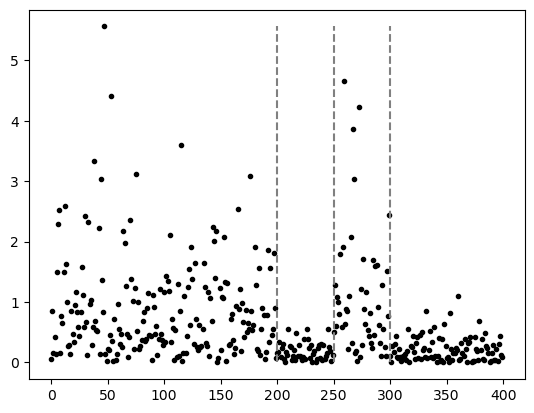

In [7]:
plot_time_series(time_series, change_points)

# Question 2

Derive a cost function that is appropriate for the data simulated in Question 1. Briefly justify your choice (in a comment in your code).

## Respuesta 2

Supongamos que sabemos que los puntos simulados tienen distribución exponencial pero no sabemos con qué parámetro $\lambda$, para cada uno de los intervalos entre `CP` y `CP`. Para ello utilizaremos como función de costo el logaritmo negativo de la función de verosímilitud. Pero antes debemos hallar para qué valor de $\lambda$ este valor es mínimo manteniendo constante los valores de $y_i$ para todo $0 < i \le n$. Note que hallar el valor mínimo es equivalente a hallar el valor máximo de la misma función positiva, lo cual sería el método del máximo verosímil. Dada cada $y_i$, debemos maximizar:

$$ L(\lambda | y_1...y_n) =  \lambda e^{-\lambda y_1} \cdot ... \cdot \lambda e^{-\lambda y_n} = \lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i} $$

Sin embargo esto es equivalente a maximizar:

$$ \log(\lambda^n e^{-\lambda \sum_{i = 1}^{n} y_i}) = \log(\lambda^n) + \log(e^{-\lambda \sum_{i = 1}^{n} y_i}) = n\log(\lambda) -\lambda \sum_{i = 1}^{n} y_i $$

Por último derivamos e igualamos a $0$ para encontrar este valor:

$$ 0 = \frac{dL(n\log(\lambda) -\lambda \sum_{i = 1}^{n} y_i)}{d\lambda} = \frac{n}{\lambda} - \sum_{i = 1}^{n} y_i$$

Y finalmente obtenemos que el valor estimado de $\lambda$ es:

$$ \lambda_{MLE} = \frac{n}{\sum_{i = 1}^{n} y_i}$$

Ahora bien, estimado $\lambda$ regresamos a nuestra función de costo versión positiva y sustituimos obteniendo:

$$ n\log(\lambda_{MLE}) -\lambda_{MLE} \sum_{i = 1}^{n} y_i = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - \frac{n}{\sum_{i = 1}^{n} y_i} \sum_{i = 1}^{n} y_i = n\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - n = n \left(\log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) - 1\right) $$

Pero como lo que queremos es minimizar más adelante con nuestros algoritmos de búsqueda de puntos de ruptura, lo que haremos es trabajar con el opuesto de este, lo que quedaría:

$$ n \left(1 - \log \left(\frac{n}{\sum_{i = 1}^{n} y_i} \right) \right) $$

Para formalizar más la función de costo, utilizaremos la notación:

$$ c(y_{a:b}) = n \left(1 - \log \left(\frac{n}{\sum_{i = a}^{b} y_i} \right) \right) $$

donde $n = b-a+1$.

In [262]:
def cost_funtion_exp(points):
    n = len(points)
    if n == 0:
        return 0     
    return len(points) * (1 - math.log(n / sum(points)))

# Question 3

Implement the optimal partition algorithm and test it on the data simulated in question 1.

## Respuesta 3

A continuación la implementación del algoritmo `Optimal Partition`, que recibe como entrada:

- La serie de tiempo
- La función de costo
- La cantidad de puntos de cambios

In [310]:
def OptimalPartition(points, cost_func, K):

    n = len(points)
    Ms = np.zeros((K,n,n))
    for u in range(n):
        for v in range(n):
            if u < v:
                Ms[0][u][v] = cost_func(points[u:v+1])

    if K > 1:
        for k in range(1, K):
            for u in range(n):
                for v in range(n):
                    if v-u > k+1:
                        Ms[k][u][v] = min([Ms[k-1][u][t] + Ms[0][t+1][v] for t in range(u+k-1, v)])
    L = np.zeros((K+1), dtype=int)
    L[K] = n-1
    k = K
    while k > 0:
        s = L[k]        
        ts = [Ms[k-1][0][t] + Ms[0][t+1][s] for t in range(k, s)]
        ts_min =  min(ts)
        t_index = ts.index(ts_min)
        L[k-1] = t_index
        k= k -1
    return L[:-1]
    

A continuación se PRUEBA el método con el conjunto de datos simulados y se obtienen los siguientes resultados:

In [311]:
approx_change_points_OP = OptimalPartition(time_series, cost_funtion_exp, 3)
approx_change_points_OP

array([197, 247, 296])

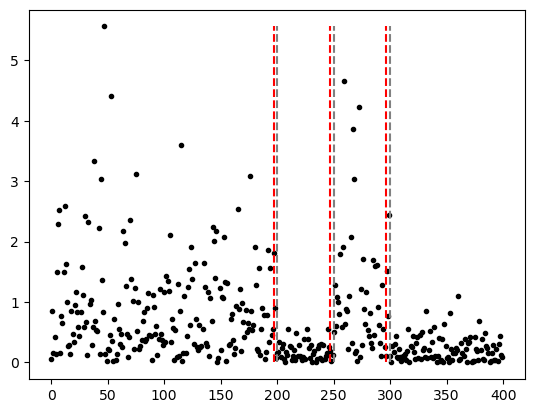

In [312]:
plot_time_series(time_series, change_points, approx_change_points_OP)

# Question 4

Implement the PELT algorithm and test it using the data simulated in question 1. You will set the value of the penalty weight as $log(n)$.

## Respuesta 4

A continuación se hace una implementación del algoritmo `PELT`. Nos basamos tanto en la implementación de Conferencia como la explicada en el artículo **"Killick, R., Fearnhead, P., & Eckley, I. A. (2012, oct). Optimal detection of changepoints with a linear computational cost. Journal of the American Statistical Association"**. Es importante señalar que PELT hace uso del **Teorema 3.1** de este artículo para descartar posibles puntos de cambios. Este Teorema expresa lo siguiente:

[ALE porfa por tu el teorema sencillito que no tiene sentido q lo traduzca al español pa que lo pongas luego en inlges. Solo hace falta el enunciado, NO la demostración]

Luego el seudocódigo de nuestro algoritmo sería:

**Input**:
- `data` $= \{y_1,...,y_n\}$: conjunto de puntos
- $c(.)$: función de costo
- $\beta$: peso de penalización
- `K`: constante que satisface **Teorema 3.1**

**Initialisations**:
- `F` = $(-\beta,..., n_{min}-1 = -\beta, 0,...,0)$: vector de tamaño `n`
- `R` = $\{0\}$: conjunto inicial de posibles puntos de cambios
- `CP` = $(0,...,0)$: array de puntos de cambios asociados a cada dato

**Seudo-Code**:

- **for all** $t^* = n_{min},..., n-1$:  
    - $F[t^~] = \min_{t \in R  ~ | ~ |t^~-t| \ge n_{min} }\{F(t) + c(y_{t:t^~})+ \beta\}$
    - $\overline{t} = \argmin_{t \in R  ~ | ~ |t^~-t| \ge n_{min} }\{F(t) + c(y_{t:t^~-1})+ \beta\}$
    - $ CP[t^~] = \overline{t} $
    - $ R^* = \{ t^~ \} \cup \{ t \in R ~ | ~ F[t] + c(y_{t:t^~-1}) + K < F[t^~]\} $
    - $ R = R^*$
- **end for**
- `last = CP[n-1]`
- **while** `last != 0` :
    - **add** `last` **to** `changes_points`
    - `last = CP[last]`
- **end while**  

**Output**
- `changes_points`: Changes Points

In [277]:
def PELT(points, cost_func, penalty= None, n_min=0, K= 0):

    n = len(points)
    F = np.zeros(n, np.float32)

    if penalty is None:
        penalty = np.log(n)

    for i in range(n_min):
        F[i] = - penalty
    CP = np.zeros(n, np.int32)
    R = np.array([0], dtype=np.int32)

    for t_accent in range(n_min, n):
        
        np.array(F[t_accent])         
        interval_costs = np.zeros(R.shape[0], np.float32)
        interval_costs_pen = []
        for i, change_point_cand in enumerate(R):            
            interval_costs[i] = F[change_point_cand] + cost_func(points[change_point_cand: t_accent])
            if abs(R[i] - t_accent) >= n_min:
                interval_costs_pen.append((interval_costs[i] + penalty, R[i]))

        F[t_accent], CP[t_accent] = min(interval_costs_pen)
        
        R_new = []
        for i, val in enumerate(interval_costs):
            if val + K < F[t_accent]:
                R_new.append(R[i])
        R_new.append(t_accent)
        R = np.array(R_new, dtype=np.int32)

    finals_CP = []
    last = CP[-1]
    while last > 0:
        finals_CP.append(last)
        last = CP[last]
    finals_CP.reverse()
    return finals_CP

Por último para PROBAR nuestro implementación utilziaremos el conjunto de datos simulados, y tomaremos como:

- $\beta = \log(n)$
- $K = 0$ ya según el artículo mencionado, es con este valor que se satisface el **Teorema 3.1**

Los resultados obtenidos se muestran a continuación:

In [278]:
approx_change_points_PELT = PELT(time_series, cost_funtion_exp)
approx_change_points_PELT

[199, 250, 300]

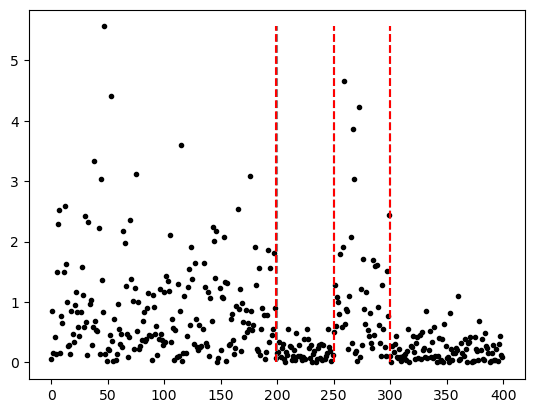

In [279]:
plot_time_series(time_series, change_points, approx_change_points_PELT)

# Question 5

Test the PELT algorithm with other values of the penalty weight. Comment the results.

In [293]:
approx_change_points_PELT_2 = PELT(time_series, cost_funtion_exp, penalty= 1/2 * np.log(len(time_series)))
approx_change_points_PELT_2

[199, 250, 300]

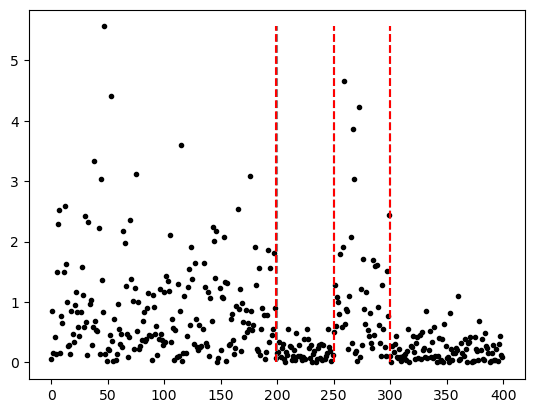

In [294]:
plot_time_series(time_series, change_points, approx_change_points_PELT_2)